In [1]:
from SimPEG import *
import simpegDCIP as DC

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 10 days


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from numpy.polynomial import polynomial

In [4]:
cs = 0.5
mesh = Mesh.TensorMesh([np.ones(100)*cs, np.ones(50)*cs], "CN")
x = mesh.vectorCCx

In [5]:
actx = (x>-15.)&(x<15.)

In [6]:
c = np.r_[0,1,2,1,-1,-3]
V = polynomial.polyvander(x, 3)
# dobs = V.dot(c)
dobs1 = 1.5*np.sin(0.2*x)
dobs2 = 1.5*np.sin(0.4*x)-3
dobs = dobs1+dobs2
# dobs = x*0.25

In [7]:
H = np.dot(V.T, V)
g = np.dot(V.T, dobs)
mest = np.linalg.solve(H, g)

In [8]:
dpred = V.dot(mest)

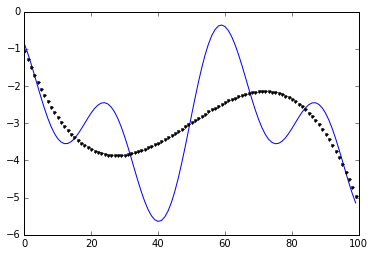

In [9]:
# plot(dobs1, 'k-')
# plot(dobs2, 'k.')
plot(dobs, 'b')
plot(dpred, 'k.')

\begin{eqnarray}
    m = e^{m_1} + (e^{m_2}-e^{m_1})(\frac{tan^{-1}(\alpha \ f(\vec{r},c))}{\pi}+0.5) 
\end{eqnarray}

\begin{align*}
        \frac{\partial m}{\partial m_1} = e^{m_1}-e^{m_1}tan^{-1}(\frac{\alpha \ f}{\pi}+0.5)
\end{align*}

\begin{align*}
        \frac{\partial m}{\partial m_2} = e^{m_2}tan^{-1}(\frac{\alpha \ f}{\pi}+0.5)
\end{align*}

\begin{align*}
        \frac{\partial m}{\partial c} = (e^{m_2}-e^{m_1})\frac{\partial f}{\partial c}\frac{\alpha}{1+(\alpha f)^2}\frac{1}{\pi}
\end{align*}

# Step1: Check derivative for "c"

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    3.094e-01     3.773e-15      nan
 1   1.00e-02    3.094e-02     4.012e-15      -0.027
 2   1.00e-03    3.094e-03     4.142e-15      -0.014
 3   1.00e-04    3.094e-04     3.840e-15      0.033
 4   1.00e-05    3.094e-05     3.793e-15      0.005
 5   1.00e-06    3.094e-06     3.841e-15      -0.006
 6   1.00e-07    3.094e-07     3.818e-15      0.003
========================= PASS! =========================
Well done Sgkang!



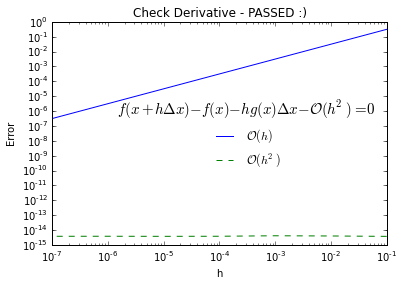

True

In [10]:
kernel =  lambda m: V.dot(m)
derChk = lambda m: (kernel(m), lambda v: kernel(v) )
Tests.checkDerivative(derChk, mest, dx = mest*0.1)

# Step2: Check $\frac{\partial m}{\partial c}$ 

In [11]:
def Poly2Dmap(m1, m2, c, xy):
    alpha = 1e4
    f = polynomial.polyval(xy[:,0], c) - xy[:,1]
    m = m1+(m2-m1)*(np.arctan(alpha*f)/np.pi+0.5)
    return m

\begin{align*}
        \frac{\partial m}{\partial c} = (e^{m_2}-e^{m_1})\frac{\partial f}{\partial c}\frac{\alpha}{1+(\alpha f)^2}\frac{1}{\pi}
\end{align*}

In [12]:
def Poly2DmapDeriv(m1, m2, c, xy):
    alpha = 1e4
    V = polynomial.polyvander(xy[:,0], len(c)-1)
    f = polynomial.polyval(xy[:,0], c) - xy[:,1]    
    deriv = Utils.sdiag(alpha*(m2-m1)/(1.+(alpha*f)**2)/np.pi)*V
    return deriv

In [13]:
kernel = lambda x: Poly2Dmap(1., 2., x, mesh.gridCC)
kernel_deriv = lambda x: Poly2DmapDeriv(1., 2., x, mesh.gridCC)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.435e+00     2.364e+00      nan
 1   1.00e-02    9.528e-01     9.383e-01      0.401
 2   1.00e-03    1.880e-03     2.262e-04      3.618
 3   1.00e-04    1.736e-04     2.031e-06      2.047
 4   1.00e-05    1.724e-05     2.012e-08      2.004
 5   1.00e-06    1.723e-06     2.010e-10      2.000
 6   1.00e-07    1.723e-07     2.010e-12      2.000
========================= PASS! =========================
Happy little convergence test!



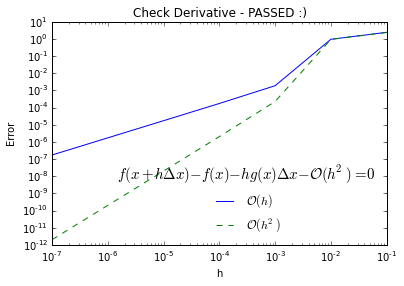

True

In [14]:
derChk = lambda m: (kernel(m), lambda v: np.dot(kernel_deriv(m), v) )
Tests.checkDerivative(derChk, mest, dx = mest*0.1)

In [15]:
from SimPEG.Maps import IdentityMap, PolyMap, ActiveCells

In [16]:
actind = (mesh.gridCC[:,0]>-15.) & (mesh.gridCC[:,0] <15.)

In [17]:
meshact = Mesh.TensorMesh([mesh.hx[actx],mesh.hy], x0 = np.r_[ -15., mesh.x0[1]])

(<matplotlib.collections.QuadMesh at 0x10f64f190>,)

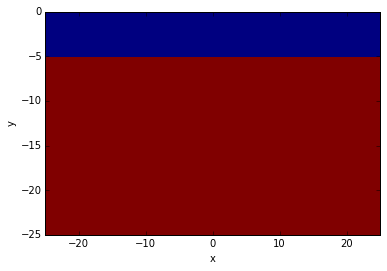

In [18]:
sigma0 = np.ones(mesh.nC)*1e0
sigma0[mesh.gridCC[:,1]>-5] = 1e-2
mesh.plotImage(sigma0)

In [19]:
actmap = ActiveCells(mesh, actind, sigma0)

In [20]:
weight = (1./(V**2).sum(axis=0))**0.5
weight = weight / weight.max()

In [21]:
m1D = Mesh.TensorMesh([V.shape[1]+2])
weightmap = Maps.Weighting(m1D, weights=np.r_[1., 1., weight])

In [22]:
polymap = PolyMap(mesh, V.shape[1]-1, logSigma=True)

In [23]:
mapping = polymap*weightmap
# mapping = polymap

In [24]:
polymap.test()

Testing PolyMap(5000,6)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.566e+01     2.652e+01      nan
 1   1.00e-02    4.919e+00     4.924e+00      0.731
 2   1.00e-03    1.202e+00     1.201e+00      0.613
 3   1.00e-04    8.527e-03     4.682e-03      2.409
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
Get on it Sgkang!



False

In [25]:
mtrue = np.r_[np.log(1e-2), np.log(1e0), mest / weight]
m0 = np.r_[np.log(1e-2), np.log(1e-2), np.r_[-3., np.zeros(V.shape[1]-1)] / weight]

In [26]:
# mtrue = np.r_[np.log(1e-2), np.log(1e0), mest]
# m0 = np.r_[np.log(1e-2), np.log(1e0), np.r_[-3., np.zeros(V.shape[1]-1)]]

In [27]:
sigma = mapping*mtrue

In [28]:
# actind = (mesh.gridCC[:,0] > -15) & (mesh.gridCC[:,0] < 15)
# meshact = Mesh.TensorMesh([mesh.hx, mesh.hy], x0=mesh.x0)
# actmap = Maps.ActiveCells(mesh, actind, 2e-3)

In [29]:
xr = np.linspace(-15, 15, 20)
xz_A = Utils.ndgrid(xr, np.r_[-0.25])
xz_B = Utils.ndgrid(np.ones_like(xr)*22, np.r_[-0.25])
xz_M = Utils.ndgrid(xr, np.r_[-0.25])
xz_N = Utils.ndgrid(np.ones_like(xr)*-22, np.r_[-0.25])

ntx = xz_A.shape[0]
txList = []
for i in range(ntx):
    offset = abs(xz_A[i,0]-xz_M[:,0])
    actrx = offset > 5.
    rx = DC.RxDipole(xz_M[actrx,:], xz_N[actrx,:])
    src = DC.SrcDipole([rx], xz_A[i,:], xz_B[i,:])
    txList.append(src)

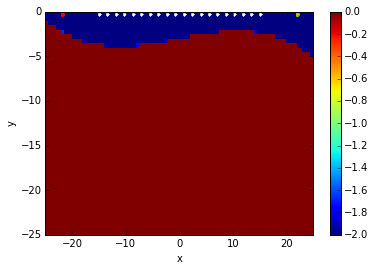

In [30]:
dat = mesh.plotImage(np.log10(sigma), clim=(-2, 0))
plt.colorbar(dat[0])
plot(xz_A[:,0], xz_A[:,1], 'w.')
plot(xz_B[:,0], xz_B[:,1], 'y.')
plot(xz_N[:,0], xz_N[:,1], 'r.')

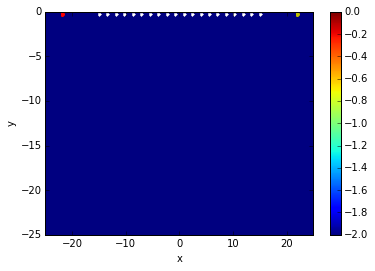

In [31]:
dat = mesh.plotImage(np.log10(mapping*m0), clim=(-2, 0))
plt.colorbar(dat[0])
plot(xz_A[:,0], xz_A[:,1], 'w.')
plot(xz_B[:,0], xz_B[:,1], 'y.')
plot(xz_N[:,0], xz_N[:,1], 'r.')

In [32]:
survey = DC.SurveyDC(txList)
problem = DC.ProblemDC_CC(mesh, mapping = mapping)
problem.pair(survey)

In [33]:
from pymatsolver import MumpsSolver
problem.Solver = MumpsSolver

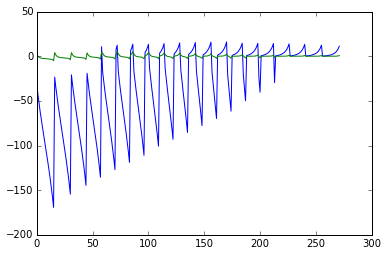

In [34]:
dini = survey.dpred(m0)
dtrue  = survey.dpred(mtrue)
plot(dini)
plot(dtrue)

In [35]:
mtrue.shape

(6,)

<matplotlib.colorbar.Colorbar instance at 0x10e63bd40>

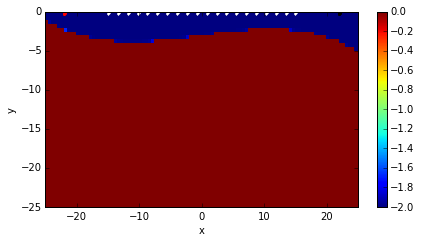

In [36]:

figsize(14*0.5,7*0.5)
circmodelest = mapping*mtrue
dat = mesh.plotImage(np.log10(circmodelest))
plot(xz_A[:,0], xz_A[:,1], 'w.')
plot(xz_B[:,0], xz_B[:,1], 'k.')
plot(xz_N[:,0], xz_N[:,1], 'r.')
# plot(temp.rxList[0].locs[0][:,0], temp.rxList[0].locs[0][:,1], 'bo')
plt.colorbar(dat[0])

In [37]:
noise = 0.1*abs(dtrue)*np.random.randn(dtrue.shape[0])

In [38]:
survey.dobs = dtrue +noise
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(0.1*abs(dtrue)+abs(dini).min()*0.1)
reg = Regularization.BaseRegularization(m1D)
opt = Optimization.InexactGaussNewton(maxIter=50,tolX=1e-3, maxIterLS=20)
opt.remember('xc')
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 0.
betaSched = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
targetmis = Directives.TargetMisfit()
savemodel = Directives.SaveModelEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaSched,targetmis])
reg.mref = m0
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  0.00e+00  3.03e+07  0.00e+00  3.03e+07    5.48e+07      0              
   1  0.00e+00  3.76e+06  6.07e-01  3.76e+06    7.39e+06      0              
   2  0.00e+00  4.84e+05  2.24e+00  4.84e+05    1.00e+06      0   Skip BFGS  
   3  0.00e+00  6.42e+04  4.70e+00  6.42e+04    1.38e+05      0   Skip BFGS  
   4  0.00e+00  1.12e+04  7.69e+00  1.12e+04    2.05e+04      0   Skip BFGS  
   5  0.00e+00  3.63e+03  1.07e+01  3.63e+03    2.81e+03      0   Skip BFGS  
   6  0.00e+00  3.13e+03  1.23e+01  3.13e+03    3.00e+02      0   Skip BFGS  
   7  0.00e+00  2.99e+03  1.28e+01  2.99e+03    8.26e+02      4              
   8  0

In [45]:
# invProb.beta = 0.
# mopt = inv.run(mopt)

In [46]:
XC = opt.recall('xc')

In [47]:
from ipywidgets import interact, IntSlider

In [51]:
def viewInv(iteration):
    fig  = plt.figure(num=0,figsize = (10,5))
    ax = plt.subplot(111)
    dat = mesh.plotImage(np.log10(mapping*XC[iteration]), grid=False, ax=ax, clim=(-2, 0))
#     ax.set_xlim(mesh.vectorNx.min(), mesh.vectorNx.max())
#     ax.set_ylim(mesh.vectorNy.min(), mesh.vectorNy.max())
    ax.plot(mesh.vectorCCx, dpred, 'w.-')
#     plt.colorbar(dat[0], ax=ax)
#     ax.set_ylim (-15, 0.)
#     ax.set_xlim (-15, 15.)
    plt.show()
    return True

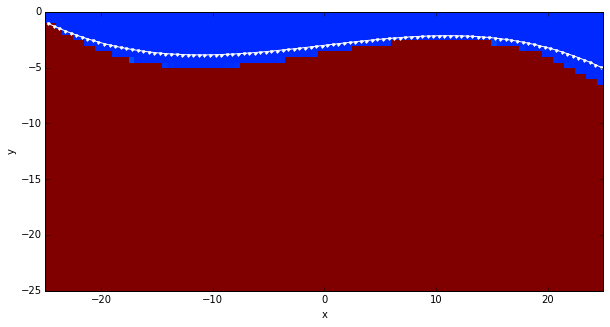

True

In [52]:
interact(viewInv, iteration = IntSlider(min=0, max=opt.iter-1,step=1, value=0))

<matplotlib.colorbar.Colorbar instance at 0x113b12ab8>

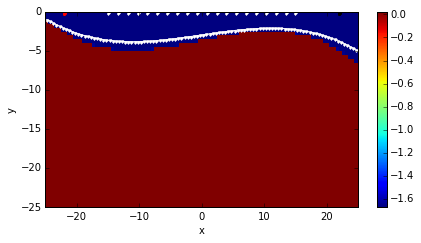

In [50]:

figsize(14*0.5,7*0.5)
circmodelest = mapping*mopt
dat = mesh.plotImage(np.log10(circmodelest))
plot(xz_A[:,0], xz_A[:,1], 'w.')
plot(xz_B[:,0], xz_B[:,1], 'k.')
plot(xz_N[:,0], xz_N[:,1], 'r.')
plot(mesh.vectorCCx, dpred, 'w.-')
# plot(temp.rxList[0].locs[0][:,0], temp.rxList[0].locs[0][:,1], 'bo')
plt.colorbar(dat[0])